In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'market1501:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F398471%2F765452%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T033452Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db30f2aaf6fc0ddd996d9411a89b9385e6ec112530e163f4d4e2796b7686e702037c5d63d045b543dc21ba40b0cf17dd1c2d05d756694d37d342d849b39d44bfbc2ae7aa53e3ff9a073e7680e15945d3b566dd1fe90bb19db28ce8fd05796017e3c9e5d6ae5a394de1410f014672c6a7cd6638ba8ead1ecf5771225cd4576641d0b75c211ef630b8256e883592431a746f240b832642dd667baf30df54987f1cca5631739d16a0f489f5c9b3ead742cd48a43bc3d8475edfd434af2068f5545fb912a306b425452a31b2bf5cdb22a335f9bcf62b47ca6cb632153aedab6fc90f59a9f5abf1adec3e1a90286179b5bdf42fcfd8d04c2ae321cacdea531e2654fe1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 153011595 bytes downloaded
Downloaded and uncompressed: market1501
Data source import complete.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os

BB_train=[]
files=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if dirname=='/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train':
            BB_train.append(os.path.join(dirname,filename))
            files.append(filename)

In [4]:
len(BB_train)

12937

# **Libraries**

In [5]:
from matplotlib import pyplot as plt,image as mpimg
from torch.optim import Adam
from torchvision import transforms as transforms
from torchvision.models import resnet50
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import torch.optim as optim
from torchvision.models.resnet import Bottleneck
from PIL import Image

In [6]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
resnet_model = resnet50(pretrained=True)
modules = []
for child in resnet_model.children():
    modules.append(child)
resnet_model = nn.Sequential(*modules[:-2])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


In [8]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [9]:
modified_resnet = []
for child in resnet_model.children():

    if isinstance(child, nn.Sequential):
      # print(child)
      for i,block in enumerate(child.children()):
            modified_resnet.append(block)
            if i!=0 and isinstance(block, Bottleneck):
              print("King") # Check if the layer is a Bottleneck block
              modified_resnet.append(SEBlock(block.conv3.out_channels))
    else:
      modified_resnet.append(child)
      # print(f'uppers: {child}')

resnet_model = nn.Sequential(*modified_resnet)

King
King
King
King
King
King
King
King
King
King
King
King


In [ ]:
resnet_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, 

# **Data Preparation**

In [ ]:
X=[]
y=[]
for i in range(len(BB_train)):
    if files[i][0:4]!='Thum':
        X.append(BB_train[i])
        y.append(int(files[i][0:4]))

In [ ]:
min(y),max(y)

(2, 1500)

In [ ]:
def display_image(image_path):
    img = mpimg.imread(image_path)
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

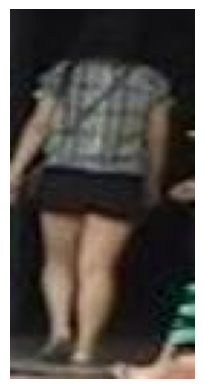

In [ ]:
display_image(X[1000])

In [ ]:
label_mapping={lab:i for i,lab in enumerate(set(y))}
y=[label_mapping[i] for i in y]

In [ ]:
image_mapping={i:[] for i in set(y)}
for i in range(len(y)): image_mapping[y[i]].append(i)

def Prepare_data(x,y):
    X_train=[];y_train=[]
    for i,img in enumerate(x):
        label=y[i]
        if len(image_mapping[label])<15:
            not_same = 30 - len(image_mapping[label])
            for img in image_mapping[label]:
              X_train.append([x[i],x[img]])
              y_train.append(1)
            not_same_data = set()
            while len(not_same_data)<not_same:
              diff_label=random.choice(list(image_mapping.keys()))
              while diff_label==label:
                diff_label=random.choice(list(image_mapping.keys()))
              ind2=random.choice(image_mapping[diff_label])

              not_same_data.add(x[ind2])

            for img in not_same_data:
              X_train.append([x[i],img])
              y_train.append(0)

        else:
          idx_list = random.sample(image_mapping[label], 15)
          for idx in idx_list:
            X_train.append([x[i],x[idx]])
            y_train.append(1)

          not_same_data = set()
          while len(not_same_data)<15:
              diff_label=random.choice(list(image_mapping.keys()))
              while diff_label==label:
                diff_label=random.choice(list(image_mapping.keys()))
              ind2=random.choice(image_mapping[diff_label])

              not_same_data.add(x[ind2])

          for img in not_same_data:
              X_train.append([x[i],img])
              y_train.append(0)

    return X_train,y_train


X_train,y_train=Prepare_data(X,y)
len(X_train),len(y_train),X_train[0],y_train[0]

(388080,
 388080,
 ['/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0969_c1s4_069611_03.jpg',
  '/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0969_c1s4_061511_03.jpg'],
 1)

In [10]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), #Flip the image horizontally randomly
    transforms.RandomRotation(degrees=10), #Randomly rotates the image by 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #Randomly change the brightness, contrast, saturation and hue of an image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
class SiameseDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # img1_path, img2_path = self.X[idx]
        img1_path, img2_path = self.X[idx][0], self.X[idx][1]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = self.Y[idx]
        label = torch.tensor(label, dtype=torch.float32)

        return img1, img2, label



In [ ]:
dataset = SiameseDataset(X_train,y_train, transform=transform)
# dataset=dataset[:int(0.3*len(dataset))]
len(dataset)

388080

In [ ]:
reduced_size = int(0.3 * len(dataset))
print(type(dataset))
# Split the dataset into two parts
dataset, _ = random_split(dataset, [reduced_size, len(dataset) - reduced_size])
print(len(dataset),type(dataset),len(_))


train_size = int(0.7 * len(dataset))
print(type(dataset))
# Split the dataset into two parts
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
print(len(dataset),type(dataset),len(test_dataset))

<class '__main__.SiameseDataset'>
116424 <class 'torch.utils.data.dataset.Subset'> 271656
<class 'torch.utils.data.dataset.Subset'>
81496 <class 'torch.utils.data.dataset.Subset'> 34928


In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
len(dataloader),len(test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(2547, 1092)

# **Architecture**

In [12]:
class Contrastive_loss_fn(nn.Module):
    def __init__(self, margin):
        super(Contrastive_loss_fn, self).__init__()
        self.margin = torch.tensor(margin, device='cuda') # Specify device for margin

    def forward(self,output1,output2,label):
        euclidean_distance=F.pairwise_distance(output1,output2,keepdim=True)
        loss_contrastive = torch.mean((label)*torch.pow(euclidean_distance, 2) +
                                     (1-label)*torch.pow(torch.clamp(euclidean_distance, min=self.margin), 2))
        return loss_contrastive


class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height) # 2048x49
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        return out





class SiameseNetwork(nn.Module):
    def __init__(self,model,attention_model):
        super(SiameseNetwork,self).__init__()
        self.encoder_model=model
        self.attention_layer=attention_model
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Add this line
        self.Dence_layer=nn.Linear(2048,1000)
        self.relu=nn.ReLU()


    def encode_one_image(self,input):
        output=self.encoder_model(input)
        output=self.attention_layer(output)
        output = self.global_avg_pool(output)
        output = output.view(output.size(0), -1)
        output=self.Dence_layer(output)
        output=self.relu(output)
        return output

    def forward(self,input1,input2):
        output1 = self.encode_one_image(input1)
        output2 = self.encode_one_image(input2)

        return output1, output2





In [ ]:

def Train_one_epoch(epochs,dataloader,model,criterion):
    for no in range(epochs):
        total_loss = 0
        for i, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            # print(output1.shape,output2.shape)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            if i % 10 == 0:
              print(f"Epoch {no+1}, Iteration {i}: Loss = {loss.item()}")
        print(f"Epoch avg Loss = {total_loss/len(dataloader)}")


In [ ]:
def test(dataloader,model,criterion):
  with torch.no_grad():
        total_loss = 0
        for i, (img1, img2, label) in enumerate(test_dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            # print(output1.shape,output2.shape)
            loss = criterion(output1, output2, label)
            total_loss += loss.item()
        print(f"Test avg Loss = {total_loss/len(test_dataloader)}")

In [13]:
# Initialize the Siamese Network
attention = SelfAttention(2048)
model = SiameseNetwork(resnet_model,attention)
model = model.to(device)
criterion = Contrastive_loss_fn(0.3)
# optimizer = optim.Adam(model.parameters(), lr=0.00035)
optimizer = optim.SGD(model.parameters(), lr=0.00035, momentum=0.9)
Train_one_epoch(1,dataloader,model,criterion)


In [14]:
from google.colab import drive
drive.mount('/content/drive')  #21bce180@nirmauni.ac.in


torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Minor/model_parameters.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RuntimeError: Parent directory /content/drive/MyDrive/Projects/Minor does not exist.

In [ ]:
from torch.optim.lr_scheduler import StepLR

# ... (your model and optimizer initialization)

optimizer = optim.SGD(model.parameters(), lr=0.00035, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)  # Reduce LR by factor of 0.1 every 10 epochs

Train_one_epoch(10,dataloader,model,criterion)
torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Minor/model_parameters.pth')

Epoch 1, Iteration 0: Loss = 0.03726208955049515
Epoch 1, Iteration 10: Loss = 0.048356276005506516
Epoch 1, Iteration 20: Loss = 0.05939691141247749
Epoch 1, Iteration 30: Loss = 0.045573510229587555
Epoch 1, Iteration 40: Loss = 0.04275985807180405
Epoch 1, Iteration 50: Loss = 0.05384758114814758
Epoch 1, Iteration 60: Loss = 0.053821392357349396
Epoch 1, Iteration 70: Loss = 0.03724953532218933
Epoch 1, Iteration 80: Loss = 0.048332858830690384
Epoch 1, Iteration 90: Loss = 0.0455479770898819
Epoch 1, Iteration 100: Loss = 0.05663195997476578
Epoch 1, Iteration 110: Loss = 0.05384539067745209
Epoch 1, Iteration 120: Loss = 0.05104349926114082
Epoch 1, Iteration 130: Loss = 0.04824519157409668
Epoch 1, Iteration 140: Loss = 0.0427241176366806
Epoch 1, Iteration 150: Loss = 0.051062632352113724
Epoch 1, Iteration 160: Loss = 0.042718615382909775
Epoch 1, Iteration 170: Loss = 0.056646376848220825
Epoch 1, Iteration 180: Loss = 0.04548206180334091
Epoch 1, Iteration 190: Loss = 0.0538

KeyboardInterrupt: 

In [ ]:
print(test(dataloader,model,criterion))
torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Minor/model_parameters.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test avg Loss = 0.04882938231959011
None


In [ ]:
for i in range(8):
  Train_one_epoch(10,dataloader,model,criterion)
  test(test_dataloader,model,criterion)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()
imgs=['/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0002_c1s1_000451_03.jpg',
'/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0002_c1s1_000551_01.jpg',
 '/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0010_c3s3_076019_01.jpg',
 '/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0010_c6s4_002452_02.jpg',
  '/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0022_c3s1_044676_01.jpg',
      '/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_train/0022_c4s1_045251_01.jpg'
]

images=[transform(Image.open(i).convert("RGB")) for i in imgs]
image_input = torch.tensor(np.stack(images)).cuda()

outputs=[]
with torch.no_grad():
  for i in range(len(image_input)):
    outputs.append(model.encode_one_image(image_input[i].unsqueeze(0)))

  # o1,o2=Siamese_model(image_input[0].unsqueeze(0),image_input[1].unsqueeze(0))
similar_images=[]
for i in range(len(imgs)):
  temp=[]
  for j in range(len(imgs)):
    temp.append(F.pairwise_distance(outputs[i],outputs[j]).item())
  similar_images.append(temp)
similar_images

[[3.162277789670043e-05,
  0.027829360216856003,
  0.02837388962507248,
  0.020096540451049805,
  0.018667908385396004,
  0.029032189399003983],
 [0.027836786583065987,
  3.162277789670043e-05,
  0.028744854032993317,
  0.021859431639313698,
  0.02584858238697052,
  0.025455748662352562],
 [0.028383227065205574,
  0.02874688059091568,
  3.162277789670043e-05,
  0.024337653070688248,
  0.03253386169672012,
  0.03316869959235191],
 [0.020105455070734024,
  0.021858172491192818,
  0.024334128946065903,
  3.162277789670043e-05,
  0.02201194316148758,
  0.022080177441239357],
 [0.018663691356778145,
  0.02583753876388073,
  0.03252329304814339,
  0.02200022153556347,
  3.162277789670043e-05,
  0.024694250896573067],
 [0.029040152207016945,
  0.025456713512539864,
  0.033167678862810135,
  0.022082535549998283,
  0.024706797674298286,
  3.162277789670043e-05]]

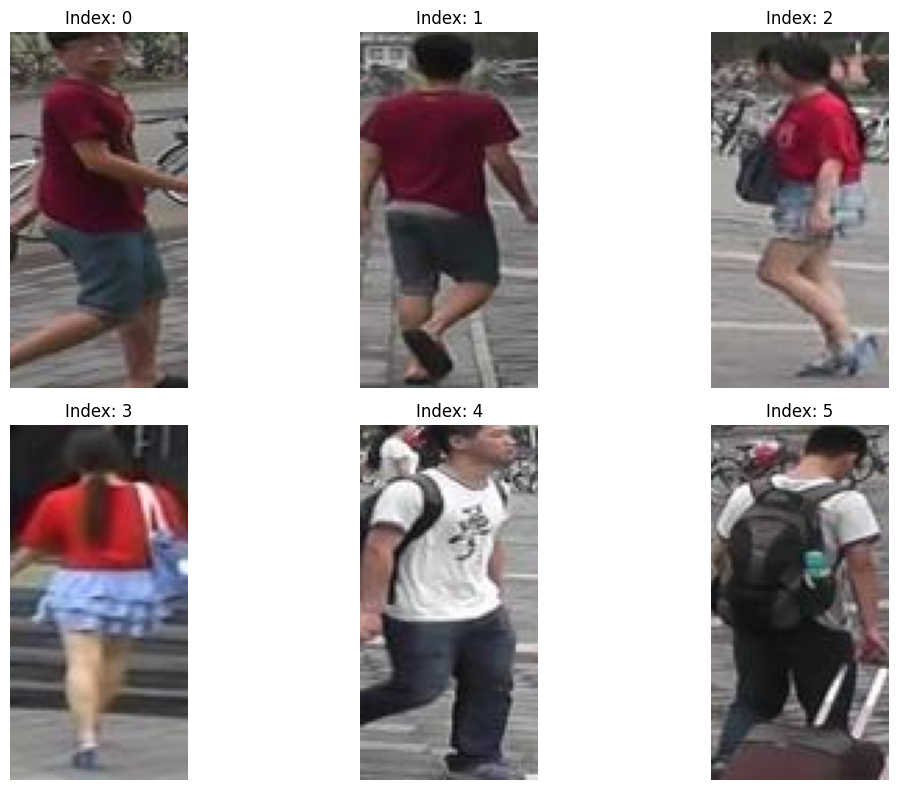

In [ ]:
num_cols = 3  # Number of columns
num_rows = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Adjust figsize as needed

# Iterate through images and display them
for i, img_path in enumerate(imgs):
    row = i // num_cols
    col = i % num_cols
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Index: {i}")
    axes[row, col].axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

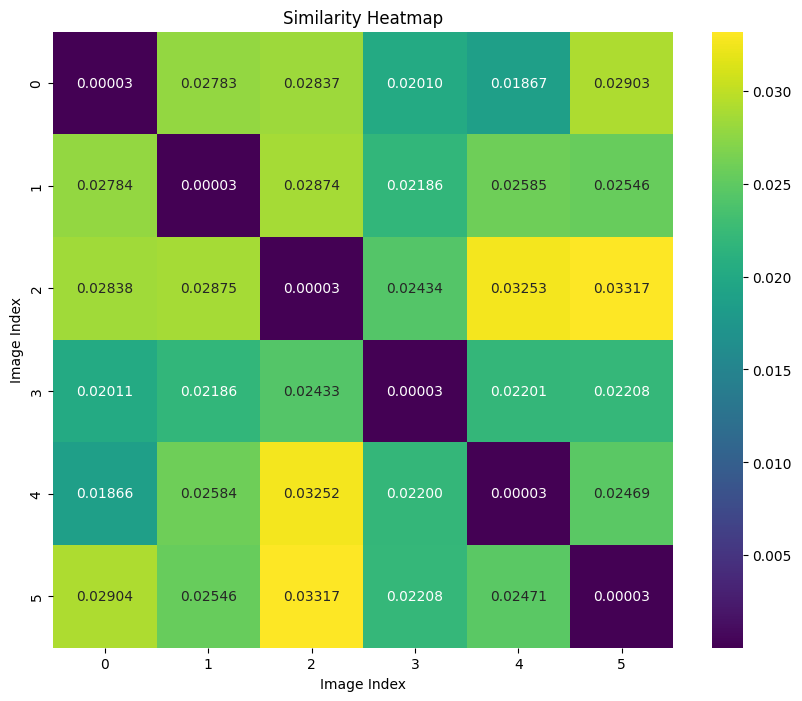

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'similar_images' is your list of lists
plt.figure(figsize=(10, 8))
sns.heatmap(similar_images, annot=True, cmap='viridis', fmt=".5f")
plt.title("Similarity Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

# Trying on **bounding_box_test** and **query**

In [15]:
# Assuming your model is named 'model' and saved parameters are in 'model_parameters.pth'
model.load_state_dict(torch.load('model_parameters.pth'))

<ipython-input-15-ff1c53ba156d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_parameters.pth'))


<All keys matched successfully>

In [16]:
import numpy as np
import pandas as pd
import os


mat_files=[]
files=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if dirname=='/kaggle/input/market1501/Market-1501-v15.09.15/gt_query':
            mat_files.append(os.path.join(dirname,filename))
            files.append(filename)
len(mat_files),len(files)


(6736, 6736)

In [18]:
mat_files[2]

'/kaggle/input/market1501/Market-1501-v15.09.15/gt_query/0768_c6s2_070293_00_good.mat'

In [19]:

from scipy import io


mat_contents = io.loadmat(mat_files[2])
mat_contents


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jan 20 15:50:40 2014',
 '__version__': '1.0',
 '__globals__': [],
 'good_index': array([[13616, 13617, 13618, 13619, 13620]], dtype=uint16)}

In [22]:
from PIL import UnidentifiedImageError



# Load query images and extract features
query_dir = '/kaggle/input/market1501/Market-1501-v15.09.15/query'
query_images=[]
query_embeddings = []

for filename in os.listdir(query_dir):
  try:
    img = Image.open(os.path.join(query_dir, filename))
    query_images.append(os.path.join(query_dir, filename))
  except UnidentifiedImageError:
    print(f'could not open {os.path.join(query_dir, filename)}')



# Load gallery images and extract features
gallery_dir = '/kaggle/input/market1501/Market-1501-v15.09.15/bounding_box_test'
gallery_images=[]
gallery_embeddings = []
for filename in os.listdir(gallery_dir):
  try:
    img = Image.open(os.path.join(gallery_dir, filename))
    gallery_images.append(os.path.join(gallery_dir, filename))
  except UnidentifiedImageError:
    print(f'could not open {os.path.join(query_dir, filename)}')



could not open /kaggle/input/market1501/Market-1501-v15.09.15/query/Thumbs.db
could not open /kaggle/input/market1501/Market-1501-v15.09.15/query/Thumbs.db


In [23]:
class Query_Dataset(Dataset):
  def __init__(self,query_images,transform):
    self.query_images=query_images
    self.transform=transform
  def __len__(self):
    return len(self.query_images)
  def __getitem__(self,idx):
    img=self.transform(Image.open(self.query_images[idx]))
    return img

class Gallery_Dataset(Dataset):
  def __init__(self,gallery_images,transform):
    self.gallery_images=gallery_images
    self.transform=transform
  def __len__(self):
    return len(self.gallery_images)
  def __getitem__(self,idx):
    img=self.transform(Image.open(self.gallery_images[idx]))
    return img



query_loader=DataLoader(Query_Dataset(query_images,transform),batch_size=32,shuffle=False)
gallery_loader=DataLoader(Gallery_Dataset(gallery_images,transform),batch_size=32,shuffle=False)




In [24]:
len(query_loader),len(gallery_loader)

(106, 617)

In [25]:
query_embeddings=None
for i,query_batch in enumerate(query_loader):
    try:
      with torch.no_grad():
        embeddings = model.encode_one_image(query_batch.to(device))
      if query_embeddings is None:
        query_embeddings = embeddings
      else:
        query_embeddings = torch.cat((query_embeddings, embeddings), dim=0)

    except :
      print(f'could not open a file')

print(len(query_embeddings),len(query_images))




galary_embeddings=None
for i,gallery_batch in enumerate(gallery_loader):
    try:
      with torch.no_grad():
        embeddings = model.encode_one_image(gallery_batch.to(device))
      if galary_embeddings is None:
        galary_embeddings = embeddings
      else:
        galary_embeddings = torch.cat((galary_embeddings, embeddings), dim=0)
    except :
      print(f'could not open a file')

print(len(galary_embeddings),len(gallery_images))

3368 3368
19732 19732


In [26]:
galary_embeddings.shape,query_embeddings.shape

(torch.Size([19732, 1000]), torch.Size([3368, 1000]))

In [29]:
type(galary_embeddings),type(query_embeddings)

(torch.Tensor, torch.Tensor)

In [39]:
# Assuming query_embeddings is a tensor of shape (num_queries, embedding_dim)
# and gallery_embeddings is a tensor of shape (num_gallery, embedding_dim)

# Batch size
batch_size = 32

# Calculate distances in batches
distances = None
for i in range(0, len(query_embeddings), batch_size):
  query_batch = query_embeddings[i:i+batch_size]
  batch_distances = torch.nn.functional.pairwise_distance(query_batch.unsqueeze(1), galary_embeddings)
  if distances is None:
    distances = batch_distances
    print(distances.shape,batch_distances.shape)

  else:
    print(distances.shape,batch_distances.shape)
    distances = torch.cat((distances, batch_distances), dim=0)

# Concatenate distances from all batches if necessary
distances.shape

torch.Size([32, 19732]) torch.Size([32, 19732])
torch.Size([32, 19732]) torch.Size([32, 19732])
torch.Size([64, 19732]) torch.Size([32, 19732])
torch.Size([96, 19732]) torch.Size([32, 19732])
torch.Size([128, 19732]) torch.Size([32, 19732])
torch.Size([160, 19732]) torch.Size([32, 19732])
torch.Size([192, 19732]) torch.Size([32, 19732])
torch.Size([224, 19732]) torch.Size([32, 19732])
torch.Size([256, 19732]) torch.Size([32, 19732])
torch.Size([288, 19732]) torch.Size([32, 19732])
torch.Size([320, 19732]) torch.Size([32, 19732])
torch.Size([352, 19732]) torch.Size([32, 19732])
torch.Size([384, 19732]) torch.Size([32, 19732])
torch.Size([416, 19732]) torch.Size([32, 19732])
torch.Size([448, 19732]) torch.Size([32, 19732])
torch.Size([480, 19732]) torch.Size([32, 19732])
torch.Size([512, 19732]) torch.Size([32, 19732])
torch.Size([544, 19732]) torch.Size([32, 19732])
torch.Size([576, 19732]) torch.Size([32, 19732])
torch.Size([608, 19732]) torch.Size([32, 19732])
torch.Size([640, 19732])

torch.Size([3368, 19732])

In [41]:
distances.argsort(dim=1).shape

torch.Size([3368, 19732])